# MuSLIT : Multi-band Sparse Linear Inversion Tool

Preliminary tests for an adaptation of principle of SLIT in the formulation of non-negative matrix factorization (NMF). 

We first make use of the following libraries, at least for these tests :
- **PySAP** for efficient wavelet transforms
- **proxmin** for NMF optimizer (Block-SDMM)

_some $\LaTeX$ definitions_
$\newcommand{\mat}[1]{\mathsf{#1}}$
$\newcommand{\matind}[2]{\mathsf{#1}_{#2}}$
$\newcommand{\RoneD}[1]{\mathbb{R}^{#1}}$
$\newcommand{\RtwoD}[2]{\mathbb{R}^{#1\times#2}}$
$\newcommand{\RthreeD}[3]{\mathbb{R}^{#1\times#2\time#3}}$
$\newcommand{\Nps}{N_\mathrm{p,\,s}}$
$\newcommand{\Npi}{N_\mathrm{p,\,i}}$
$\newcommand{\Np}{N_\mathrm{p}}$
$\newcommand{\Nb}{N_\mathrm{b}}$
$\newcommand{\Ns}{N_\mathrm{s}}$
$\newcommand{\ie}{\emph{i.e.}}$
$\newcommand{\atiter}[1]{^{(#1)}}$
$\newcommand{\Niter}{N_{\mathrm{iter}}}$
$\newcommand{\Nsubiter}{N_{\mathrm{subiter}}}$
$\newcommand{\FISTA}[1]{\mathrm{FISTA}(#1)}$
$\newcommand{\normzero}[1]{\left\lVert #1 \right\rVert_0}$
$\newcommand{\normone}[1]{\left\lVert #1 \right\rVert_1}$
$\newcommand{\normtwo}[1]{\left\lVert #1 \right\rVert_2}$
$\newcommand{\fidelity}{\mathcal{D} \left( \mat{Y}\, |\, \mat{A_S},\, \mat{A_G},\, \mat{S},\, \mat{G} \right)}$

$\renewcommand{\algorithmicrequire}{\textbf{Input:}}$
$\renewcommand{\algorithmicensure}{\textbf{Output:}}$

$\DeclareMathOperator*{\argmin}{arg\,min}$

## Problem statement (ignoring PSF for now)

The problem we want to solve can be written as the following minimizatiton problem, with forward model $\mat{Y}=\mat{A\,S}$.

- Synthesis formulation :
\begin{align}
        \argmin_{\mat{A},\,\alpha_\mat{G},\,\alpha_\mat{S}}&\ \normtwo{\mat{Y}-\mat{A}
        \begin{bmatrix}
            \left(\mat{F_\kappa}\Phi^\top\alpha_\mat{S}\right)^\top \\
            \left(\Phi^\top\alpha_\mat{G}\right)^\top
        \end{bmatrix}
        }^2 + i_{\cdot\geq0}\!\left(\mat{A}\right) + i_{\cdot\geq0}\!\left(\Phi^\top\alpha_\mat{S}\right) + i_{\cdot\geq0}\!\left(\Phi^\top\alpha_\mat{G}\right) + g_1\!\left(\mat{A}\right) + \lambda_\mat{S}\normzero{\alpha_\mat{S}} + \lambda_\mat{G}\normzero{\alpha_\mat{G}}
\end{align}


- Analysis formulation (preferred, but no prox for $\normzero{\Phi\mat{X}}$ !!) :
\begin{align}
        \label{eq:final_eq_analysis}
        \argmin_{\mat{A},\,\mat{G},\,\mat{S}}&\ \normtwo{\mat{Y}-\mat{A}
        \begin{bmatrix}
            \left(\mat{F_\kappa}\mat{S}\right)^\top \\
            \mat{G}^\top
        \end{bmatrix}
        }^2 + i_{\cdot\geq0}\!\left(\mat{A}\right) + i_{\cdot\geq0}\!\left(\mat{S}\right) + i_{\cdot\geq0}\!\left(\mat{G}\right) + g_1\!\left(\mat{A}\right) + \lambda_\mat{S}\normzero{\alpha_\mat{S}} + \lambda_\mat{G}\normzero{\alpha_\mat{G}}
\end{align}

For implementation practicity, the constraint $i_{\cdot\geq0}\!\left(\Phi^\top\alpha_\mat{S}\right)$ may be applied as $i_{\cdot\geq0}\!\left(\mat{F_\kappa}\Phi^\top\alpha_\mat{S}\right)$. Both formulations are equivalent, since $\mat{F_\kappa}$ is non-negative.

#### Adding the PSF convolution

The forward model becomes $\mat{Y}=\mat{H}*\mat{A\,X}$, with $\mat{H}*\cdot$ being the PSF convolution in each band :
\begin{align}
        \mat{H} =
        \begin{bmatrix}
            \mat{H_1} & & \\
             & \ddots & \\
             & & \mat{H}_{\Nb}
        \end{bmatrix}
\end{align}

In [1]:
import os
import sys
import PIL
import copy
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits

from pylensmodels.mass.spemd import SPEMD_glee
from pylensmodels.light.gaussian import Gaussian, GaussianElliptical
from pylensmodels.utils import coordinates

import MuSLIT.utils.plot as plot_utils
from MuSLIT.lensing import planes
from MuSLIT.simulation import quick_sim

lin = lambda x: x
log = lambda x: np.log10(x)

# 1. Generate a mock lens
Lens mass model : SPEMD (using GLEE parameter conventions)
Lens light model : Spherical gaussian
Source light model : Elliptical gaussian

In [2]:
sim_lens_multiband = quick_sim.simple_multiband_lens(sigma_noise=0.05)

Deflection angles have been provided


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


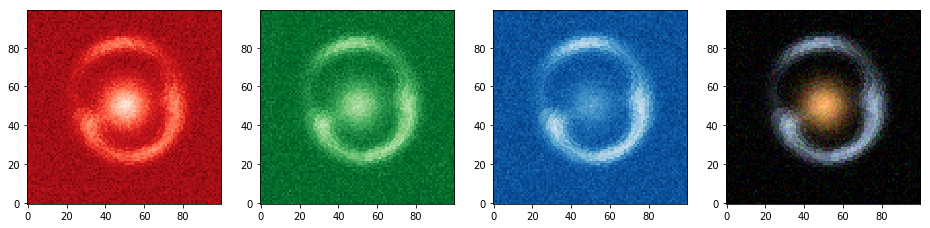

In [4]:
plot_utils.plot_rgb_bands(sim_lens_multiband)

# 2. Reconstruct the source using _MuSLIT_